In [6]:
from glob import glob

for g in glob("./data/*.pdf"):
    print(g)
    

./data/2040_seoul_plan.pdf


In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=100):
    """
    pdf 파일을 읽어서 텍스트로 변환하고, 텍스트를 잘게 쪼개서 리스트로 반환합니다.

    매개변수:
        pdf_path: str
            텍스트로 변환할 pdf 파일의 경로
        chunk_size: int
            쪼갤 텍스트의 최대 길이
        chunk_overlap: int
            쪼개진 텍스트 조각 간의 겹치는 길이
    """

    print(f"PDF : {pdf_path} ---------------")

    pdf_loader = PyPDFLoader(pdf_path)
    data_from_pdf = pdf_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    splits = text_splitter.split_documents(data_from_pdf)

    print(f"Number of splits: {len(splits)}\n")

    return splits

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from dotenv import load_dotenv
import os
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
embedding = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=OPENAI_API_KEY,
)

# 절대 경로 사용
persist_directory = "../chroma_store"

if os.path.exists(persist_directory):
    print("Loading existing Chroma store")
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding,
    )
else:
    print("Creating new Chroma store")
    vectorstore = None

    for g in glob("./data/*.pdf"):
        chunks = read_pdf_and_split_text(g)

        # 100개씩 나눠서 저장
        for i in range(0, len(chunks), 100):
            if vectorstore is None:
                vectorstore = Chroma.from_documents(
                    documents=chunks[i:i+100],
                    embedding=embedding,
                    persist_directory=persist_directory,
                )
            else:
                vectorstore.add_documents(
                    documents=chunks[i:i+100],
                )



Creating new Chroma store
PDF : ./data/2040_seoul_plan.pdf ---------------
Number of splits: 308



In [20]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

chunks = retriever.invoke("서울 온실가스 저감 계획")

for chunk in chunks:
    print(chunk.metadata)
    print(chunk.page_content)

{'page_label': '46', 'creationdate': '2024-12-12T18:16:11+09:00', 'moddate': '2024-12-12T18:16:11+09:00', 'source': './data/2040_seoul_plan.pdf', 'page': 45, 'total_pages': 205, 'creator': 'Hwp 2020 11.0.0.5178', 'pdfversion': '1.4', 'producer': 'Hancom PDF 1.3.0.542', 'author': 'SI'}
기후변화에 대응하기 위한 온실가스 적극 감축 및 녹색 인프라 확충 등을 강조하고 있다.Ÿ2040 서울도시기본계획의 부문별 전략계획과 공간계획에서는 서울의 글로벌 경쟁력 강화, 광역화에 따른 수도권 내 교통, 산업 등 네트워크 연계 강화, 기후위기에 대응하기 위한 지속가능한 서울로의 전환 등 수도권정비기본계획의 주요 내용을 적극적으로 반영하여 수립하였다.
{'pdfversion': '1.4', 'creator': 'Hwp 2020 11.0.0.5178', 'producer': 'Hancom PDF 1.3.0.542', 'page': 63, 'total_pages': 205, 'source': './data/2040_seoul_plan.pdf', 'moddate': '2024-12-12T18:16:11+09:00', 'page_label': '64', 'creationdate': '2024-12-12T18:16:11+09:00', 'author': 'SI'}
56제2장 미래상과 목표
6. 미래위기를 준비하는, ‘탄소중립 안전도시 구축’1) 배경전(全) 지구적인 기후변화에 대응하기 위한 대도시 차원의 대응 필요Ÿ서울시 2017년 온실가스 배출량은 46,685천 톤CO2eq로 2005년 배출량에 비해 5.6%(276만 톤CO2eq) 감소하였으며, 서울의 1인당 온실가스 배출량은 4.7CO2eq로 국가의 13.8톤CO2eq에 비해 낮은 수준이다. 또한 2014년 기준

In [14]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)
model.invoke("안녕하세요!")

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CDuNkDSgPeMDz4NplY4fMsVT0L3FF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f9e434d4-d164-48cd-ace4-722f8b6f3cb8-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
from pydantic import BaseModel, Field

class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성이 높은 데이터 소스로 라우팅 합니다."""
    datasource: Literal["vectorstore", "casual_talk"] = Field(
        ...,
        description="""
        사용자 질문에 따라 casual_talk 또는 vectorstore 중 하나를 선택합니다.
        - casual_talk: 사용자 질문이 일상적인 대화 내용인 경우
        - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우
        """,
    )


#### 사용자의 질문을 받고 판단하기

In [16]:
structured_llm_router = model.with_structured_output(RouteQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual_talk 중 하나로 라우팅하는 전문가입니다.
- vectorstore에는 서울, 뉴욕의 발전계획과 관련된 문서가 포함되어있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
- 사용자의 질문이 일상 대화와 관련된 경우에는 casual_talk를 사용하십시오.
"""

router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_system),
        ("human", "{question}"),
    ]
)

question_router = router_prompt | structured_llm_router



In [17]:
print(
    question_router.invoke({
        "question": "서울의 온실가스 저감 계획은 무엇인가요?"
    })
)

print(
    question_router.invoke({
        "question": "비 오는 날 저녁 식사 메뉴를 추천해줘."
    })
)



datasource='vectorstore'
datasource='casual_talk'


In [18]:
from langchain_core.prompts import PromptTemplate

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성이 있는지 yes 또는 no로 평가합니다."""

    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 평가합니다.",
    )

structured_llm_grade = model.with_structured_output(GradeDocuments)









#### 챗봇처럼 기존 대화 내용이 계속 이어질 필요가 없는 경우에는 PromptTemplate이 적합할 수 있음

In [25]:
grader_prompt = PromptTemplate.from_template(
    """
당신은 검색된 문서가 사용자의 질문과 관련이 있는지 평가하는 전문가입니다.\n
문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어있으면 해당 문서를 관련성이 있다고 평가하십시오.\n
엄격한 테스트가 필요하지 않습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다.\n
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 부여하십시오.\n

Retrieved documents: \n {document} \n\n
User question : {question}
    """
)

retrieval_grader = grader_prompt | structured_llm_grade
question = "서울시 자율주행 관련 계획"
documents = retriever.invoke(question)

for i, doc in enumerate(documents):
    print(f"# Document {index+1}:")
    print(doc)
    index += 1






# Document 6:
page_content='48제2장 미래상과 목표
-생활권 전체를 녹지와 수변이 어우러진 오픈스페이스로 구성하여 다양한 여가수요에 대응 Ÿ지역특성을 반영한 다양한 유형의 보행일상권 조성을 위한 차별화된 모델을 제시한다.-일자리 중심, 문화여가 중심, 산업공간 중심, 주거 중심 등 지역생활권 특성을 반영-서울시 전역을 100여 개 이상의 작지만 강한 자족적인 일상 생활권으로 조성하도록 유도유연한 용도지역 계획으로 공간 효율성 극대화Ÿ보행일상권 실현을 위해서는 지역에 대한 면밀한 분석을 통해 부족한 시설과 필요한 기능을 찾아내고, 유연한 용도지역을 부여하여 공간 효율성을 극대화한다.Ÿ자립적인 생활권을 조성하기 위해 생활권 계획과 연계하여 주민과 자치구 중심으로 지역이 보유한 풍부한 자원과 잠재력6)을 활용함으로써 시민 개개인의 삶의 질 향상은 물론 지역 균형발전을 도모한다.
[그림 2-22] 보행일상권 개념도
6) 서울은 360여 개의 역세권과 100여 개의 공공 보건시설, 1,000여 개의 지역 보건센터와 같은 공공의료 시스템, 1,000여 개의 공공/지역문화시설과 400여 개의 공연장과 같은 문화시설, 2,900여 개의 공원녹지와 423km의 하천을 보유 중' metadata={'source': './data/2040_seoul_plan.pdf', 'author': 'SI', 'pdfversion': '1.4', 'creationdate': '2024-12-12T18:16:11+09:00', 'creator': 'Hwp 2020 11.0.0.5178', 'producer': 'Hancom PDF 1.3.0.542', 'page_label': '56', 'total_pages': 205, 'moddate': '2024-12-12T18:16:11+09:00', 'page': 55}
# Document 7:
page_content='부문별 전략계획시민이 제안한 미래상을 구체화하기 위한 분과별 계획 수립Ÿ기간: 2019. 10. ~ 2020.

In [26]:
filtered_documents = []

for i, doc in enumerate(documents):
    
    is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(f"# Document {i+1} : {is_relevant}")
    if is_relevant.binary_score == "yes":
        filtered_documents.append(doc)

print(f"Filtered documents: {len(filtered_documents)}")



# Document 1 : binary_score='no'
# Document 2 : binary_score='no'
# Document 3 : binary_score='no'
# Document 4 : binary_score='no'
# Document 5 : binary_score='yes'
Filtered documents: 1


#### RAG를 위한 프롬프트 생성

In [ ]:
rag_generate_system = """
당신은 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 도시 계획 전문가입니다.\n
주어진 context는 vectorstore에서 검색된 결과입니다.\n
주어진 context를 기반으로 사용자의 question에 대해 답변하십시오.
===============
question: {question}
context: {context}
===============
"""

rag_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=rag_generate_system
)

rag_chain = rag_prompt | model

question = "서울시 자율주행 관련 계획"

answer = rag_chain.invoke({"question": question, "context": filtered_documents})
print(answer)





content='서울시는 자율주행 관련 계획을 다음과 같이 수립하고 있습니다:\n\n1. **자율주행 자동차 운영 체계 구축**: 서울시는 자율주행 기술이 가장 가시화된 미래 교통 기술로, 이를 위해 2030년까지 간선도로급 이상의 도로에서 자율주행차가 운영될 수 있는 인프라 환경을 조성할 계획입니다. 2040년까지는 서울 전역에서 자율주행차량의 운행 환경을 구축하고, 수송 분담률 10%를 달성하는 것을 목표로 하고 있습니다.\n\n2. **도심 항공교통(UAM) 기반 마련**: 서울시는 도심에서 김포공항까지의 시범노선을 운영하고, 장기적으로 한강 및 주요 수변 공간을 중심으로 광역노선을 확보할 계획입니다. UAM 인프라 확보를 위한 인센티브 및 도시계획적 지원 방안도 검토하고 있습니다.\n\n3. **모빌리티 허브 구축**: 서울 전역에 모빌리티 허브를 구축하여 도심 및 광역거점에서 서울 내부와 외부의 연계를 위한 미래 교통과 기존 교통을 연결하는 시설을 도입할 예정입니다. 이 허브는 교통뿐만 아니라 공공서비스, 물류, 상업 등 다양한 기능이 복합적으로 제공되는 지역 거점으로 발전할 것입니다.\n\n이러한 계획들은 서울시의 미래 교통 인프라를 선제적으로 구축하고, 다양한 통행 행태가 공존하는 포용적인 교통체계를 마련하기 위한 노력의 일환입니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 350, 'prompt_tokens': 788, 'total_tokens': 1138, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, '

### 그래프 상태 선언하고 노드 정의하기

In [32]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]




In [33]:
def route_question(state):
    """
    사용자의 질문을 vectorstore 또는 casual_talk 중 하나로 라우팅합니다.

    Args:
        state (dict) : 현재 graph state

    return:
        state (dict) : 라우팅된 데이터 소스와 사용자 질문을 포함하는 새로운 graph state
    """
    print("----- ROUTE -----")
    question = state["question"]
    route = question_router.invoke({"question": question})

    print(f"# Routing to : {route.datasource}")
    return route.datasource



In [34]:
def retrieve(state):
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.

    Args:
        state (dict) : 현재 graph state

    return:
        state (dict) : 검색된 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print("----- RETRIEVE -----")
    question = state["question"]
    
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}
    

In [35]:
def grade_documents(state):
    """
    검색된 문서를 평가하여 질문과 관련이 있는지 확인합니다.

    Args:
        state (dict) : 현재 graph state

    return:
        state (dict) : 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print("----- GRADE -----")
    question = state["question"]
    documents = state["documents"]
    filtered_documents = []

    for i, doc in enumerate(documents):
        is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        print(f"# Document {i+1} : {is_relevant}")
        if is_relevant.binary_score == "yes":
            filtered_documents.append(doc)

    return {"documents": filtered_documents, "question": question}
    

In [36]:
def generate(state):
    """
    LLM을 사용하여 문서와 사용자 질문에 대한 답변을 생성합니다.

    Args:
        state (dict) : 현재 graph state

    return:
        state (dict) : LLM 생성된 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print("----- GENERATE -----")
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"question": question, "context": documents})
    return {"question": question, "generation": generation, "documents": documents}
    
    

In [37]:
def casual_talk(state):
    """
    사용자의 질문에 대한 일상적인 대화를 처리합니다.

    Args:
        state (dict) : 현재 graph state

    return:
        state (dict) : 일상적인 대화 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print("----- CASUAL TALK -----")
    question = state["question"]
    generation = model.invoke(question)
    return {"question": question, "generation": generation}
    

### StateGraph 만들기

In [43]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("casual_talk", casual_talk)




In [44]:
workflow.add_conditional_edges(
    START, 
    route_question,
    {
        "vectorstore": "retrieve",
        "casual_talk": "casual_talk"
    }
)
workflow.add_edge("casual_talk", END)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

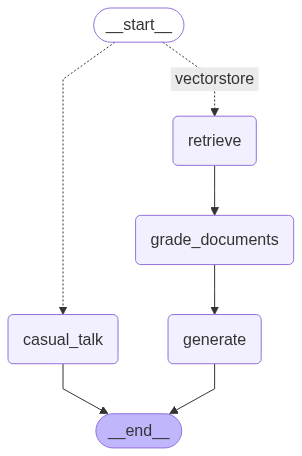

In [45]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass




In [46]:
inputs = {"question": "서울시 자율주행 관련 계획"}

app.invoke(inputs)

----- ROUTE -----
# Routing to : vectorstore
----- RETRIEVE -----
----- GRADE -----
# Document 1 : binary_score='no'
# Document 2 : binary_score='no'
# Document 3 : binary_score='no'
# Document 4 : binary_score='no'
# Document 5 : binary_score='yes'
----- GENERATE -----


{'question': '서울시 자율주행 관련 계획',
 'generation': AIMessage(content='서울시는 자율주행 관련 계획을 다음과 같이 수립하고 있습니다:\n\n1. **자율주행 자동차 운영 체계 구축**: 서울시는 자율주행 기술이 가장 가시화되고 있는 미래 교통 기술로 인식하고, 이를 위해 단계적으로 2030년까지 간선도로급 이상의 도로에서 자율주행차가 운영될 수 있는 인프라 환경을 조성할 계획입니다. 2040년까지는 서울 전역에서 자율주행차량의 운행 환경을 구축하고, 수송 분담률 10%를 달성하는 것을 목표로 하고 있습니다.\n\n2. **도심 항공교통(UAM) 기반 마련**: 서울시는 도심에서 김포공항까지의 시범노선을 운영하고, 장기적으로 한강 및 주요 수변 공간을 중심으로 광역노선을 확보할 계획입니다. UAM 인프라 확보를 위한 인센티브 및 도시계획적 지원 방안도 검토하고 있습니다.\n\n3. **모빌리티 허브 구축**: 서울 전역에 모빌리티 허브를 구축하여 도심 및 광역거점에서 서울 내부와 외부의 연계를 위한 미래 교통과 기존 교통을 연결하는 시설을 도입할 예정입니다. 이 허브는 교통뿐만 아니라 공공서비스, 물류, 상업 등 다양한 기능들이 복합적으로 제공되는 지역 거점으로 발전할 것입니다.\n\n이러한 계획들은 서울시의 미래 교통체계 구축을 위한 포괄적인 전략의 일환으로, 기술 발전에 선제적으로 대응하고 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계를 마련하기 위한 노력의 일환입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 371, 'prompt_tokens': 788, 'total_tokens': 1159, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,

In [48]:
inputs = {"question": "피곤해"}

app.invoke(inputs)

----- ROUTE -----
# Routing to : casual_talk
----- CASUAL TALK -----


{'question': '피곤해',
 'generation': AIMessage(content='피곤하군요. 충분한 휴식이 필요할 것 같아요. 잠깐 쉬거나 좋아하는 음악을 듣는 것도 좋을 것 같아요. 혹시 어떤 일이 있었나요? 이야기하고 싶다면 들어줄게요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 10, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CDvRvdVpAUz3NTEyz830NijFUkNnV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--693e58da-6059-4ce8-b22b-08ba63cb0444-0', usage_metadata={'input_tokens': 10, 'output_tokens': 51, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [49]:
inputs = {"question": "서울시 친환경 에너지 정책"}

for msg, meta in app.stream(inputs, stream_mode="messages"):
    print(msg.content, end="")


----- ROUTE -----
{"datasource":"vectorstore"}# Routing to : vectorstore
----- RETRIEVE -----
----- GRADE -----
{"binary_score":"yes"}# Document 1 : binary_score='yes'
{"binary_score":"yes"}# Document 2 : binary_score='yes'
{"binary_score":"yes"}# Document 3 : binary_score='yes'
{"binary_score":"yes"}# Document 4 : binary_score='yes'
{"binary_score":"yes"}# Document 5 : binary_score='yes'
----- GENERATE -----
서울시의 친환경 에너지 정책은 기후 변화에 대응하고 지속 가능한 도시 환경을 조성하기 위해 다양한 전략을 포함하고 있습니다. 주요 내용은 다음과 같습니다:

1. **탄소중립 목표**: 서울시는 2040년까지 탄소중립을 목표로 하고 있으며, 이를 위해 건물, 교통, 에너지 등 주요 인프라의 혁신이 필요합니다. 특히, 2026년까지 100만 호의 건물 에너지 효율화 사업을 추진하고, 신규 건물에 대해 제로에너지 건물(ZEB) 의무화를 시행할 계획입니다.

2. **신재생에너지 확대**: 서울시는 신재생에너지 보급률을 2030년까지 21%로 확대할 계획이며, 소규모 분산형 발전시설을 지원하고 지역 내 에너지 생산 및 관리 기반을 마련할 것입니다.

3. **시민 참여와 교육**: 시민의 자원순환 인식을 높이기 위한 다양한 사업과 시책을 발굴하고, 친환경 교육 계획을 수립하여 대중교통 이용 및 일회용품 사용 감축을 유도합니다.

4. **자원순환 체계 구축**: 자원순환 및 관리 자립을 위한 분산형 폐기물 처리 시설을 구축하고, 생활권 단위에서 폐기물의 감량 및 재사용·재활용을 촉진하는 기반을 마련합니다.

5. **물순환 체계 통합 관리*